# PyTorch Workflow

## Typical PyTorch Workflow Summary

A typical PyTorch workflow is a structured and five-step process for training a neural network. The best way to understand it is through an analogy of**teaching a student to pass an exam**.

Here’s the entire process at a glance:

1.  **Prepare the Data** (Get the study materials)
2.  **Build the Model** (The student's brain)
3.  **Define Loss Function & Optimizer** (The practice test and study technique)
4.  **Create the Training Loop** (The study session)
5.  **Evaluate the Model** (The final exam)


#### 1. Prepare the Data (The Study Materials)

Before a student can learn they need textbooks and notes. Similarly a model needs data. This step involves getting the data and preparing it for PyTorch.

* **What we do:** We load our data (images, text, numbers) and convert it into **tensors**, which are the fundamental data structure in PyTorch.
* **Key PyTorch tools:**
    * `torch.utils.data.Dataset`: An object that holds our entire dataset. Think of it as the complete textbook.
    * `torch.utils.data.DataLoader`: An object that wraps our `Dataset` and serves up the data in small and manageable **batches**. A student doesn't study the entire textbook at once but they study chapter by chapter. The `DataLoader` hence provides these "chapters."

#### 2. Build the Model (The Student's Brain)

Next we need to define the student—the neural network itself. It's like building a brain with layers of neurons which are ready to learn but it doesn't know anything yet.

* **What we do:** We define yur neural network architecture as a Python class.
* **Key PyTorch tools:**
    * `torch.nn.Module`: All of our models will be subclasses of this. It gives us all the core functionality.
    * `__init__()`: In this methodw you define the layers of our network (e.g., `torch.nn.Linear` for simple layers, `torch.nn.Conv2d` for image layers). This is like defining the different parts of the brain.
    * `forward()`: This method defines how data flows through the layers you created. It's the path of thinking.

#### 3. Define the Loss Function & Optimizer (The Test & Study Technique)

How does a student know if they're learning? They take a practice test. And how do they improve? They use a study technique.

* **Loss Function (The Practice Test):** This measures how wrong our model's predictions are compared to the true answers. A high loss means the model is very wrong and a low loss means it's doing well.
    * **PyTorch examples:** `nn.CrossEntropyLoss` (for classification) or `nn.MSELoss` (for regression).
* **Optimizer (The Study Technique):** This is the algorithm that updates the model's internal parameters (its "knowledge") to reduce the loss. It tells the model *how* to learn from its mistakes.
    * **PyTorch examples:** `torch.optim.Adam` or `torch.optim.SGD`.

#### 4. The Training Loop (The Study Session)

This is the core of the learning process where everything comes together. We'll loop over our data multiple times (called **epochs**) and in each loop, the model will practice, get graded, and improve.<br>
A single training step inside the loop has five parts:

1.  **Forward Pass:** The model makes a prediction on a batch of data. (`model(inputs)`)
    * *Analogy: The student answers a set of practice questions.*
2.  **Calculate Loss:** The loss function compares the model's prediction to the correct answer. (`loss_fn(...)`)
    * *Analogy: The practice test is graded yielding a score.*
3.  **Zero Gradients:** We reset the optimizer's memory of past errors. (`optimizer.zero_grad()`)
    * *Analogy: The student clears their mind before tackling the next set of questions.*
4.  **Backpropagation:** PyTorch calculates how much each parameter in the model contributed to the error. (`loss.backward()`)
    * *Analogy: The student figures out *why* they got each question wrong.*
5.  **Update Weights:** The optimizer adjusts the model's parameters based on the backpropagation results. (`optimizer.step()`)
    * *Analogy: The student corrects their understanding and updates their knowledge.*

You repeat this loop over and over until the model's performance stops improving.


#### 5. Evaluate the Model (The Final Exam)

After the study sessions are over it's time for the final exam. We test the model on **new and unseen data** to see how well it truly learned to generalize.

* **What we do:** We create a testing loop. It's similar to the training loop but with two key differences:
    1.  We use `model.eval()` mode to turn off certain layers that behave differently during training (like dropout).
    2.  We use `with torch.no_grad():` to tell PyTorch not to calculate gradients which makes evaluation faster and more memory-efficient. We're only testing not learning.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1'

### 1. Data Preparing And Loading

In [2]:
# creating known parameters
weight = 0.7
bias = 0.3

#creating the data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)# shape (50,1)
y = weight * X + bias # shape (50,1)

X[:10], y[:10]# first 10 samples

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now we will build a model that can learn the relationship between X (features) and y (labels).

- #### Splitting Data into Training and Test Sets

In [3]:
train_split = int(0.8 * len(X))# 80% of the data for training
X_train, y_train = X[:train_split], y[:train_split]# getting the training data till 80%
X_test, y_test = X[train_split:], y[train_split:]# getting the testing data from 80% to end

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
# plotting training data, test data and compares predictions
def plot_predictions(train_data = X_train, train_labels =y_train, test_data=X_test, test_labels = y_test, predictions = None):
    plt.figure(figsize=(10, 7))# creating a figure
    #plotting training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # plotting testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    if predictions is not None: #plotting the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

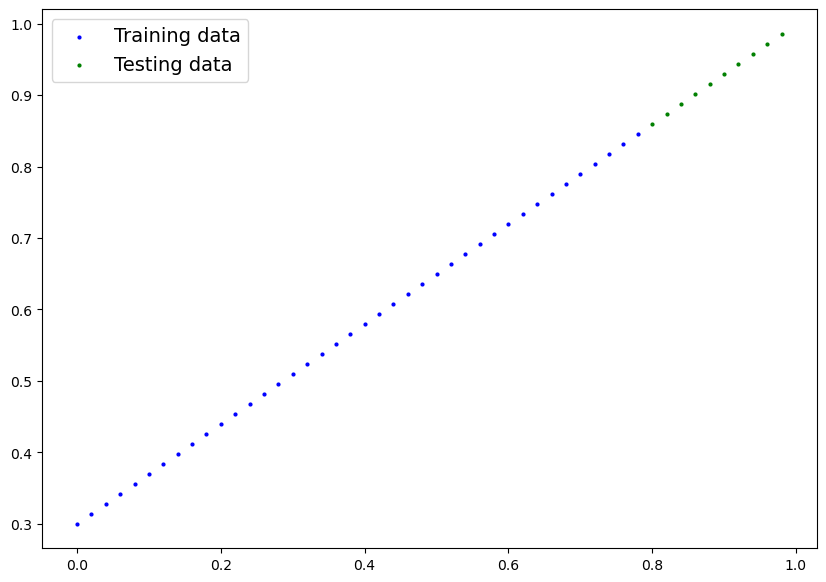

In [5]:
plot_predictions()

### 2. Building Model

In [10]:
# creating a Linear Regression model class
# almost everything in PyTorch is a nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() # calling the constructor of the parent class nn.Module
        self.weights = nn.Parameter(torch.randn(1, # random initialisation of weights starting with 1 as model learns
                                                dtype=torch.float), # dtype is float by default
                                                requires_grad=True) # we want to calculate the gradients
        # initialising bias
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),  # dtype is float by default
                                             requires_grad=True)  # we want to calculate the gradients

        
    
    #defining forward function for the purpose of making predictions
    def forward(self, x: torch.Tensor) -> torch.Tensor:# x is type torch.Tensor and the function returns a torch.Tensor
        return self.weights * x + self.bias # y = wx + b(linear regression equation)
 

#### PyTorch Model Building Essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network we can imagine.<br>
They are `torch.nn`, `torch.optim`, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

- `torch.nn`: Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
- `torch.nn.Parameter`: Stores tensors that can be used with `nn.Module`.
- `torch.nn.Module`: The base class for all neural network modules all the building blocks for neural networks are subclasses. Requires a forward() method be implemented.
- `torch.optim`: Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss).
- `def forward()`: 	All `nn.Module` subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular `nn.Module`.

#### Checking Contents of PyTorch Model

In [12]:
# creating a random seed
torch.manual_seed(42)
# creating an instance of the model
model_0 = LinearRegressionModel()
# Checking the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

Getting the state (what the model contains) of the model.

In [13]:
model_0.state_dict()# getting the state (what the model contains) of the model.

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making Predictions using `torch.inference_mode()`:

We pass the test data `X_test` to see how closely it predicts `y_test.` When we pass data to our model it'll go through the model's forward() method and produce a result using the computation we've defined.



In [14]:
#making predictions with the model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [15]:
#Checking the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


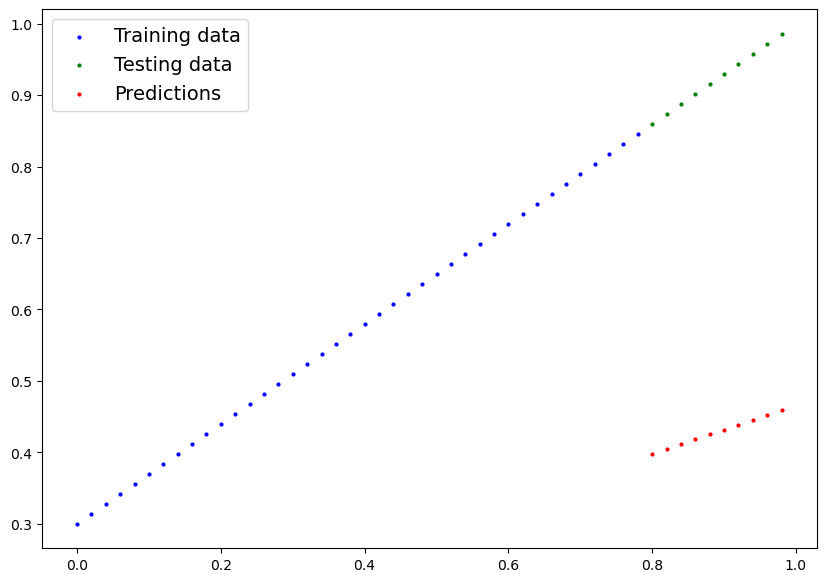

In [16]:
plot_predictions(predictions=y_preds)